In [396]:
import sys
import os

os.getcwd()
sys.path.append(os.getcwd()+'/..')

In [397]:
import scipy
import math
import numpy as np
from src.diagonalize import State, delta, neg_1_pow, Interaction, Molecule
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import total_ordering
int_wigner_arr = np.load("../src/wigner3j_integer_N=10.npy")
halfint_wigner_arr = np.load("../src/wigner3j_halfint_N=3.5.npy")
plt.rcParams['text.usetex'] = True

In [398]:
def T_int(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

def T_half_int(n3, n1, m3, m1, n2, m2, N = 7/2):
    n3 = n3 - 0.5 
    n1 = n1 - 0.5 
    
    n2 = n2
    m2 = m2 + 2 
    
    m3 = m3 + N 
    m1 = m1 + N 
    
    return int(m2 + 5 * n2 + 15 * m1 + (15+30*N)*m3 + (15+60*N+60*N*N)*n1 + (60*N*N*N + 90*N*N + 45*N + 7.5)*n3)
    
#def wigner_3j(n1, n2, n3, m1, m2, m3):
#    if n1 == int(n1) and n2 == int(n2) and n3 == int(n3):
#        return int_wigner_arr[T_int(n3,n1,m3,m1,n2,m2)]
#    return halfint_wigner_arr[T_half_int(n3,n1,m3,m1,n2,m2)]

# we will use this to allow basises with Nmax above 10
from sympy.physics.wigner import wigner_3j

h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    return wig1 * wig2 * other

int_rotational = Interaction(1, rotational)
int_stark = Interaction(1, stark)

Nmax = 20
NaCs = Molecule(range(Nmax), 0, 0)
NaCs.add_interaction(int_rotational)
NaCs.add_changing_interaction(int_stark)

NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 8, int(60))
eigenvalues_and_eigenvectors_E = NaCs.compute_eigenval_over_range([E_range])
eigenvalues = [elem[0] for elem in eigenvalues_and_eigenvectors_E]
eigenvectors = [elem[1] for elem in eigenvalues_and_eigenvectors_E]


H has dim 400


In [399]:
@total_ordering
class pendularState:
    # eigenvalue is the energy of this state
    # eigenvector is the vector corresponding to the basis weights
    # of this state
    # index is the original index of this state, before resorting
    def __init__(self, eigenvalue, eigenvector, index, basis=None):
        self.eigenvalue = eigenvalue
        self.eigenvector = eigenvector
        self.index = index
        self.basis = basis

    def inner(self, other):
        # adjust later
        return 0
    
    def expectation(self, operator, other):
        # adjust later
        return 0

    def __lt__(self, other):
        return self.eigenvalue < other.eigenvalue

    def __eq__(self, other):
        return self.eigenvalue == other.eigenvalue
    

In [400]:
len(eigenvalues[0])

400

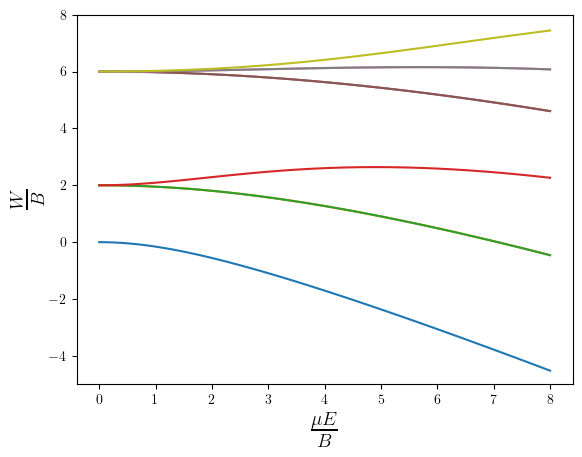

In [401]:
# each index of this array corresponds to a pendular basis
# with a different electric field strength
pendularBasises = []
for i in range(len(E_range)):
    myStates = []
    for j in range(len(eigenvalues[0])):
        myStates.append(pendularState(eigenvalues[i][j], eigenvectors[i][j], j))
    pendularBasises.append(sorted(myStates))

eigen_values_ordered_range = [[state.eigenvalue for state in states] for states in pendularBasises]
eigen_vectors_ordered_range = [[state.eigenvector for state in states] for states in pendularBasises]
plt.figure()
plt.plot(E_range, eigen_values_ordered_range)
plt.ylim(-5,8)
plt.xlabel(r'$\frac{\mu E}{B}$', fontsize = 20)
plt.ylabel(r'$\frac{W}{B}$', fontsize = 20)
plt.show()

![Screenshot 2025-02-14 011827.png](<attachment:Screenshot 2025-02-14 011827.png>)
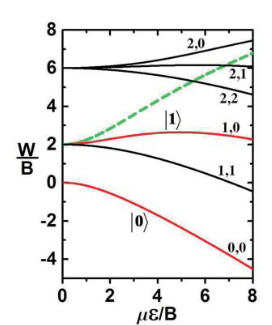

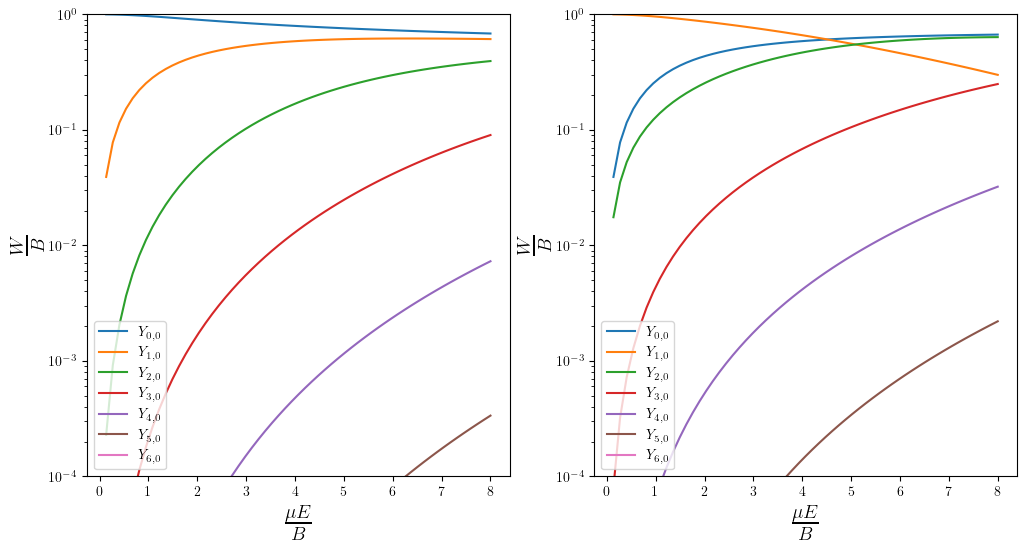

In [406]:
nstates = 2
nharmonics = 7
fig, ax = plt.subplots(1,nstates, figsize=(12,6))

j=0
indexrange = [i for i, elem in enumerate(eigen_vectors_ordered_range[59][j]) if abs(elem) != 0]
coefficients_to_plot = np.array([[pbasis[j][i] for i in indexrange[:nharmonics]] for pbasis in eigen_vectors_ordered_range]).reshape(60,nharmonics)
ax[j].plot(E_range[1:], np.abs(coefficients_to_plot[1:]), label = ['$Y_{0,0}$','$Y_{1,0}$','$Y_{2,0}$','$Y_{3,0}$','$Y_{4,0}$','$Y_{5,0}$','$Y_{6,0}$'])
ax[j].set_xlabel(r'$\frac{\mu E}{B}$', fontsize = 20)
ax[j].set_ylabel(r'$\frac{W}{B}$', fontsize = 20)
ax[j].set_yscale('log')
ax[j].set_ylim(1e-4,1)
ax[j].legend()

j=1
indexrange = [i for i, elem in enumerate(eigen_vectors_ordered_range[59][2]) if abs(elem) >= 1e-5]
coefficients_to_plot = np.array([[pbasis[2][i] for i in indexrange[:nharmonics]] for pbasis in eigen_vectors_ordered_range]).reshape(60,nharmonics)
ax[j].plot(E_range[1:], np.abs(coefficients_to_plot[1:]), label = ['$Y_{0,0}$','$Y_{1,0}$','$Y_{2,0}$','$Y_{3,0}$','$Y_{4,0}$','$Y_{5,0}$','$Y_{6,0}$'])
ax[j].set_xlabel(r'$\frac{\mu E}{B}$', fontsize = 20)
ax[j].set_ylabel(r'$\frac{W}{B}$', fontsize = 20)
ax[j].set_yscale('log')
ax[j].set_ylim(1e-4,1)
ax[j].legend()
plt.show()

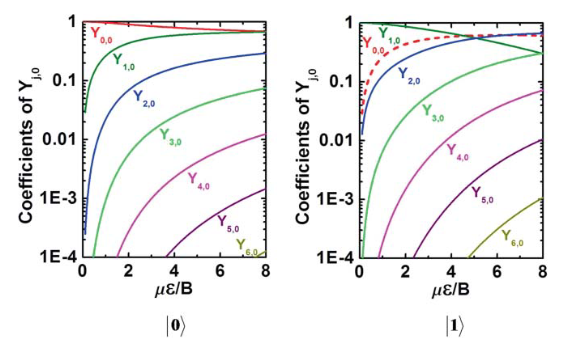